# Optimisation Discrète et Multiobjectif.

Pour traiter les problématiques d'optimisation en nombre entiers, on a recourt à la bibliothèque **CVXPY** et le solveur **CPLEX** pour avoir des résultats comparables à ceux de Matlab. pour les installer, vous pouvez décommenter la ligne qui suit.

In [1]:
#!pip install cvxpy
#!pip install cplex

In [2]:
from scipy.spatial import distance
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
%matplotlib inline

## 2.1 Rangement d'objets ( optimisation combinatoire )

On souhaite ranger N objets éparpillées sur le sol dans N boîtes alignées.

In [3]:
objects = np.loadtxt('RangerObjets/PositionObjets.txt', skiprows=1)
boxes = np.loadtxt('RangerObjets/PositionCasiers.txt', skiprows=1)

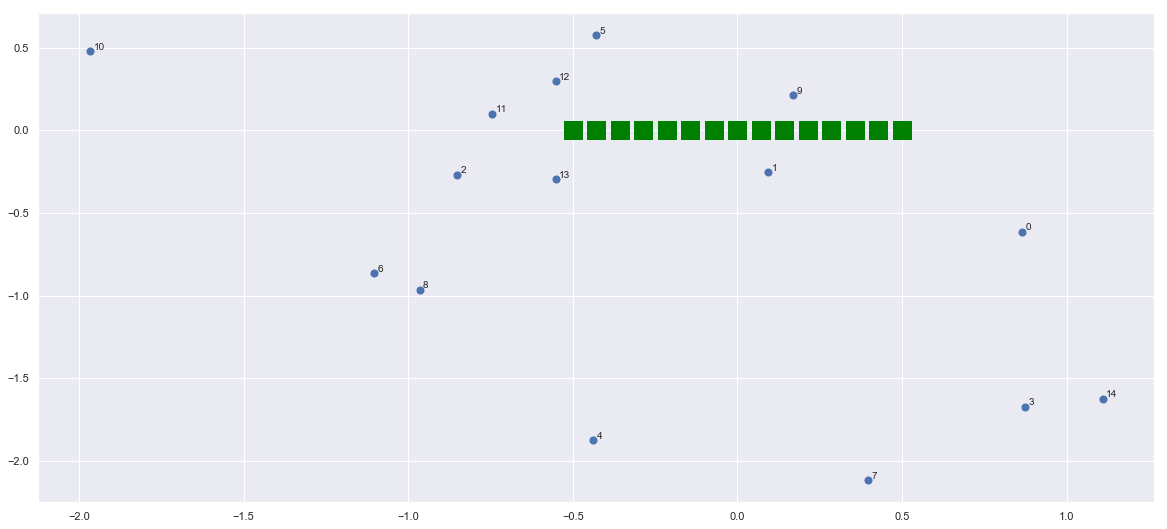

In [4]:
plt.figure(figsize=(20,9))
plt.scatter(boxes[:,0],boxes[:,1] , marker=',' , s = 300 , c='green')
plt.scatter(objects[:,0],objects[:,1],marker='o' , s = 50)
epsilon = 1e-2
for i in range(15) : 
    plt.text(objects[i,0]+epsilon,objects[i,1]+epsilon,str(i))


On définit la fonction qui à partir d'une configuration d'objets donnée, trace les affectations des objets à leurs boîtes respectives 

In [5]:
def plot_object_config(x) : 
    plt.figure(figsize=(20,9))
    plt.scatter(boxes[:,0],boxes[:,1] , marker=',' , s = 300 , c='green')
    plt.scatter(objects[:,0],objects[:,1],marker='o' , s = 50)
    epsilon = 1e-2
    for i in range(15) : 
        plt.text(objects[i,0]+epsilon,objects[i,1]+epsilon,str(i+1))

    data = np.abs(x.value.reshape(n,n))
    for i in range(15) :
        idx = np.argmax(data[i])
        plt.plot([objects[idx,0],boxes[i,0]] , [objects[idx,1],boxes[i,1]] , 'r' )
    plt.show()

**1)** 

Les deux premières contraîntes peuvent être traduites par :

- un seul objet par boîte  : $ \sum_{j=0}^{n-1} x_{i,j} = 1 \quad \forall i  $  
- tous les objets soient rangés : $ \sum_{i=0}^{n-1} x_{i,j} = 1 \quad \forall j  $


**2)**

Une première formulation du problème sera:
$$ \min\limits_{x} \sum_{i=0}^{n-1} \sum_{i=0}^{n-1} x_{i,j} \left | \left | O_j - B_i \right | \right | $$  
sous les contraintes :  $$ \sum_{j=0}^{n-1} x_{i,j} = 1    \quad \quad \quad \quad (1) $$    
$$ \sum_{i=0}^{n-1} x_{i,j} = 1  \quad \quad \quad \quad (2) $$             

Pour des problèmes d'implémentation, on introduit $ D \in \mathbb{R}^{n^2}$ le vecteur défini par : $ D_{i,j} = \left | \left | O_j - B_i \right | \right | $ 
on peut donc écrire le problème sous la forme : $ \min\limits_{x} D^{T}x  $ avec les mêmes contraintes $ (1)$ et $(2)$

La résolution de ce problème donc nous mène à la configuration suivante :

In [6]:
D = distance.cdist(boxes, objects)
n = D.shape[0]
D_flat = D.flatten()
x = cp.Variable(D_flat.shape, boolean=True)

In [7]:
A = np.zeros((2*n , n**2))
for i in range(n):
    A[i,i*n:n*(i+1)] = 1
    A[n+i, [n*j + i for j in range(n)]] = 1
    
ones = np.ones(2*n)

In [8]:
objective = cp.Minimize(cp.sum(D_flat*x))

status: optimal
optimal value 15.377627809988198


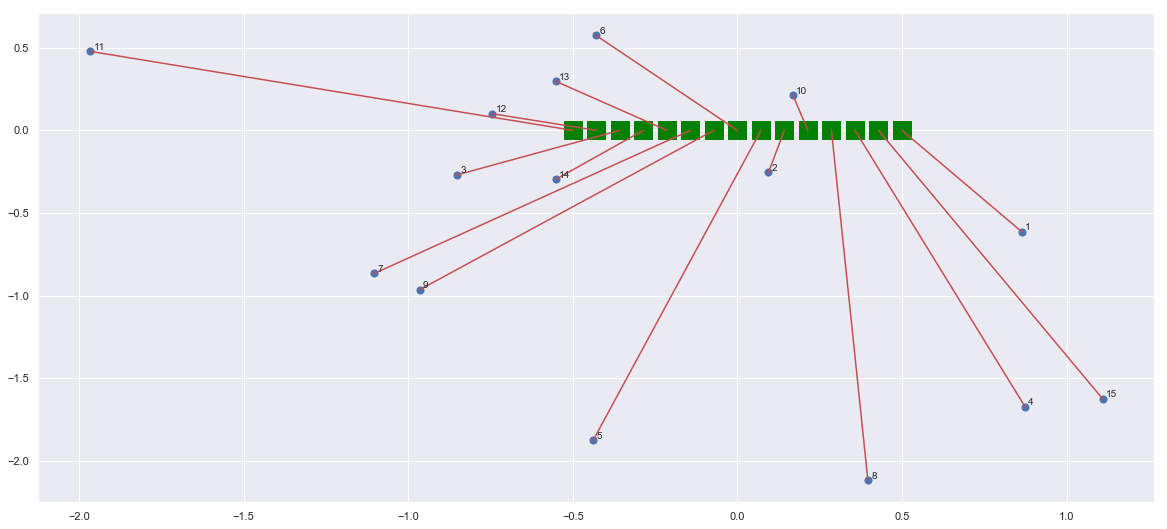

In [9]:
# constraints = [A*x == ones]
constraints = []
for i in range(n) : 
    constraints += [cp.sum(x[i*n:(i+1)*n]) == 1] 
    constraints += [cp.sum(x[[i + d*n for d in range(n)]]) == 1]
    
    
prob = cp.Problem(objective, constraints)
prob.solve()
print("status:", prob.status)
print("optimal value", prob.value)
# print("optimal var \n", np.round(np.abs(x.value.reshape(n,n)), 5))
plot_object_config(x)

**3)**

L'objet n°1 doit se trouver dans la boîte située juste à gauche de la boîte contenant l'objet n°2 est une contrainte qui peut se reformuler par :   $  x_{i,0} =  x_{i+1,1}  $ quelque soit $i$ ( quelque soit la boîte ).
on peut même la formuler en une contrainte linéaire de la forme : $ Ax = 0 $.

Avec
\begin{equation}A = (A_1,A_2,0,...,0) \in \mathbb{R}^{n,n^2} \quad  avec \quad A_1 = I_n , \quad A_2 = \begin{bmatrix} 
    0 & -1 & \dots \\
    \vdots & \ddots & -1 \\
    0 &        & 0 
    \end{bmatrix}_n
\end{equation}

La résolution est faite dans les bouts de code qui suivent :

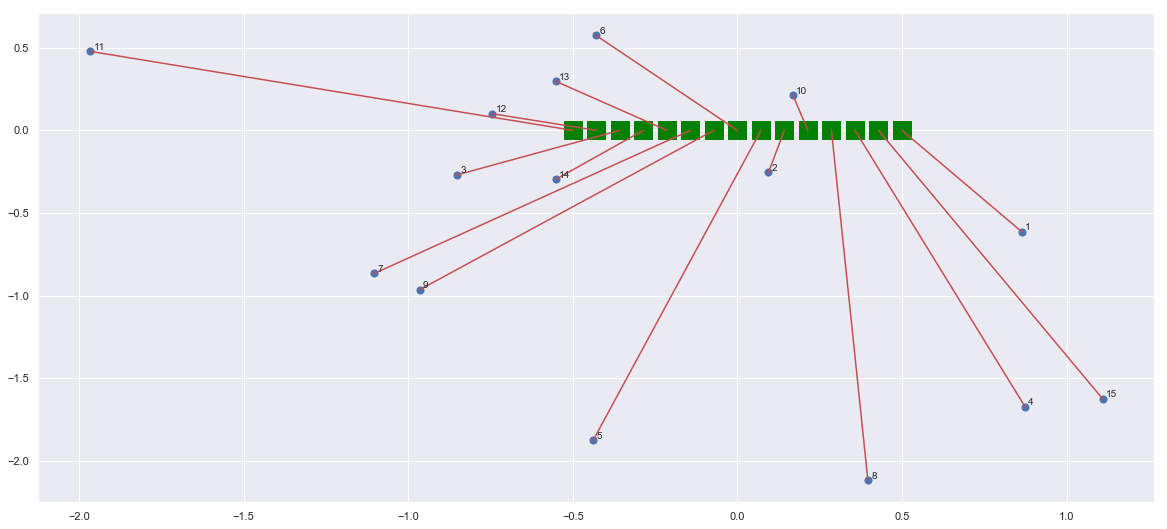

In [10]:
plt.figure(figsize=(20,9))
plt.scatter(boxes[:,0],boxes[:,1] , marker=',' , s = 300 , c='green')
plt.scatter(objects[:,0],objects[:,1],marker='o' , s = 50)
epsilon = 1e-2
for i in range(15) : 
    plt.text(objects[i,0]+epsilon,objects[i,1]+epsilon,str(i+1))

data = np.abs(x.value.reshape(n,n))
for i in range(15) :
    idx = np.argmax(data[i])
    plt.plot([objects[idx,0],boxes[i,0]] , [objects[idx,1],boxes[i,1]] , 'r')
plt.show()

**4)** 

Pour $i$ fixé, avec $x_{i,3} = 1$ la contrainte $x_{i+k,4} = 0 $ pour tout $k \gt 0 $ veut clairement dire qu'il est impossible pour l'objet n°4 de se trouver à droite de l'objet n°3. 

On la rajoutant aux contraintes de notre problème, on tombe sur les résultats qui suivent :

status: optimal
optimal value 15.901379430360375


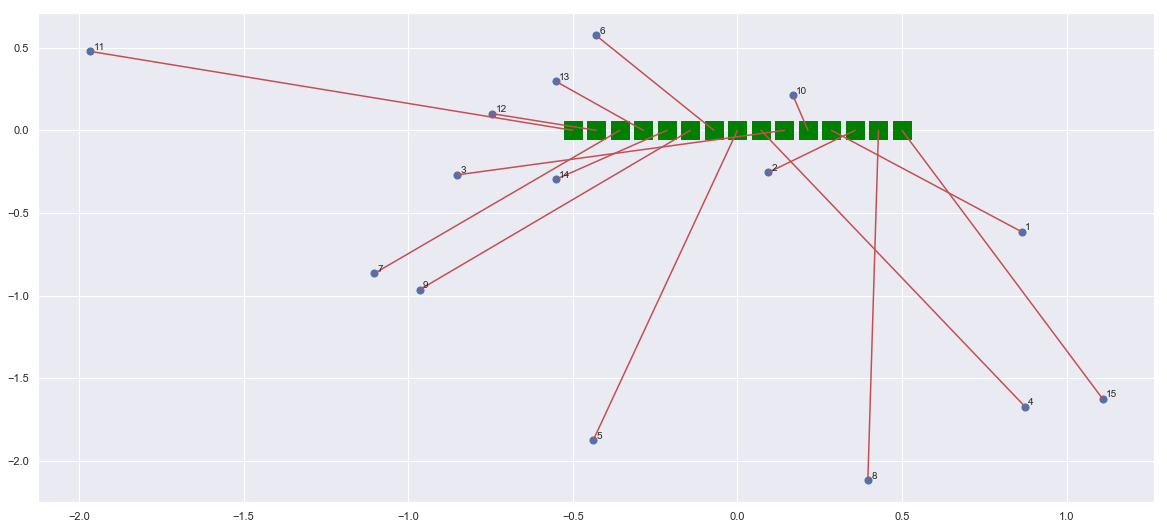

In [11]:
x = cp.Variable(D_flat.shape, boolean=True)
constraints = []
for i in range(n) : 
    constraints += [cp.sum(x[i*n:(i+1)*n]) == 1] 
    constraints += [cp.sum(x[[i + d*n for d in range(n)]]) == 1]
for i in range(n-1) : 
    constraints = constraints + [ x[i*n] == x[(i+1)*n+1]]
for i in range(n) :
    for k in range(1,n-i) : 
        constraints = constraints +  [ x[2+n*i] +x[n*(i+k)+3] <= 1]  

objective = cp.Minimize(cp.sum(D_flat*x))
prob = cp.Problem(objective, constraints )
prob.solve(solver="CPLEX")
print("status:", prob.status)
print("optimal value", prob.value)
# print("optimal var \n", np.round(np.abs(x.value.reshape(n,n)), 5))
plot_object_config(x)

**5)**

On peut proposer la modélisation suivante pour traduire que la boîte contenant l'objet n°7 se situe toujours à côté de la boite contenant l'objet n°9.

$$  \quad x_{i,7} + x_{i+k,9} \le 1 \quad \forall i \gt 0,\forall k>2 \quad $$ 
$$   \quad  x_{i,7} + x_{i-k,9} \le 1 \quad \forall i>0,\forall k>2 \quad$$ 

Ces contraintes veulent dire que si l'objet n°7 se trouve dans la boîte $i_0$, alors l'objet n°9 ne peut ếtre que dans les boîtes $i_0 -1$ ou $i_0 + 1$, et donc pour n'importe quelle boîte $k$ différente de ces deux là, la somme $x_{i,7} + x_{k,9}$ doit être inférieur ou égale à $1$. et celà pour n'importe quelle boite $i_0$, ce qui justifie bien notre formulation.


status: optimal
optimal value 15.904808342529503


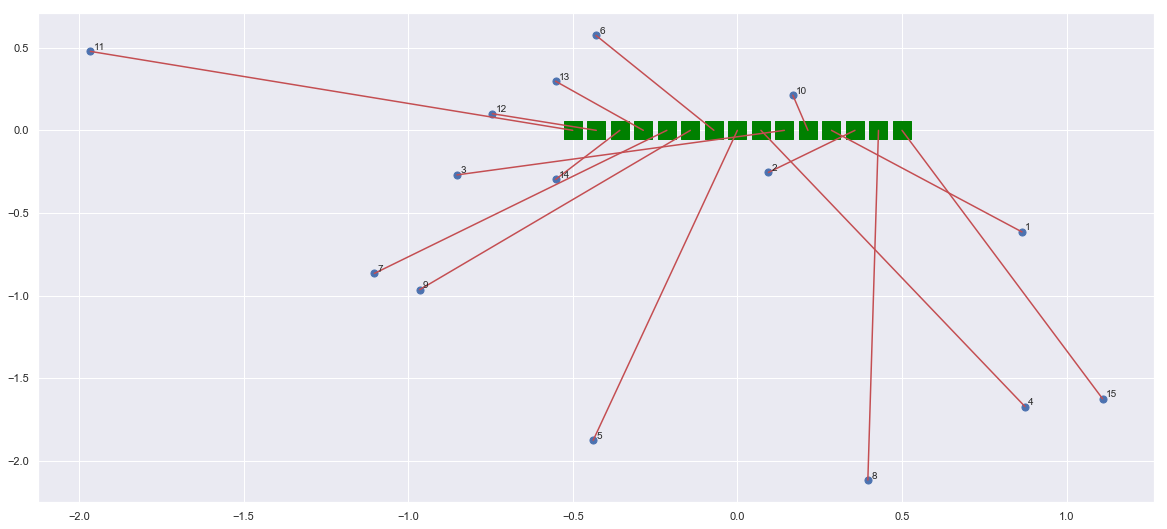

In [12]:
x = cp.Variable(D_flat.shape, boolean=True)
constraints = []
for i in range(n) : 
    constraints += [cp.sum(x[i*n:(i+1)*n]) == 1] 
    constraints += [cp.sum(x[[i + d*n for d in range(n)]]) == 1]
for i in range(n-1) : 
    constraints = constraints + [ x[i*n] == x[(i+1)*n+1]]

for i in range(n) :
    for k in range(1,n-i) : 
        constraints = constraints +  [ x[2+n*i] +x[n*(i+k)+3] <= 1]
for i in range(n) : 
    for k in range(2,n-i) :
        constraints = constraints +  [ x[n*i+8] + x[n*(i+k)+6] <= 1  ]
    for h in range(2,i+1) : 
        constraints = constraints +  [ x[n*i+8] + x[n*(i-h)+6] <= 1 ]

objective = cp.Minimize(cp.sum(D_flat*x))
prob = cp.Problem(objective, constraints)
prob.solve()
print("status:", prob.status)
print("optimal value", prob.value)
plot_object_config(x)

**6-**

Afin de vérifier que la solution obtenue est bien une solution unique ou non, on va essayer de résoudre le problème en rajoutant comme contrainte que la solution doit être différente de celle trouvé avant.


In [13]:
first_solution_x = np.round(np.abs(x.value), 5)
first_solution_min = prob.value

status: optimal
optimal value 15.904808342529503
Is the New solution equal to the old one ? :False


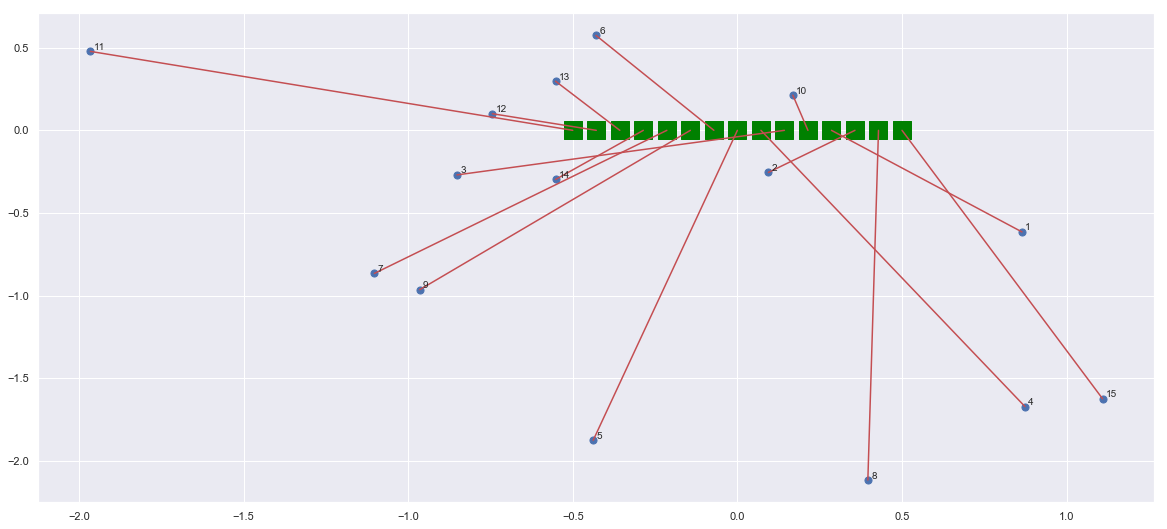

In [14]:
for p in range(n*n) : 
    x = cp.Variable(D_flat.shape, boolean=True)
    constraints = []
    for i in range(n) : 
        constraints += [cp.sum(x[i*n:(i+1)*n]) == 1] 
        constraints += [cp.sum(x[[i + d*n for d in range(n)]]) == 1]
    for i in range(n-1) : 
        constraints = constraints + [ x[i*n] == x[(i+1)*n+1]]
    for i in range(n) :
        for k in range(1,n-i) : 
            constraints = constraints +  [ x[2+n*i] +x[n*(i+k)+3] <= 1]
    for i in range(n) : 
        for k in range(2,n-i) :
            constraints = constraints +  [ x[n*i+8] + x[n*(i+k)+6] <= 1  ]
        for h in range(2,i+1) : 
            constraints = constraints +  [ x[n*i+8] + x[n*(i-h)+6] <= 1 ]
    constraints = constraints + [ x[p] == 1 - first_solution_x[p] ]

    objective = cp.Minimize(cp.sum(D_flat*x))
    prob = cp.Problem(objective, constraints)
    prob.solve() 
    if prob.value == first_solution_min : 
        print("status:", prob.status)
        print("optimal value", prob.value)
        break 

print('Is the New solution equal to the old one ? :{}'
      .format((np.round(np.abs(x.value), 5)  == first_solution_x).all()))
plot_object_config(x)

On remarque que la nouvelle solution obtenue revient seulement à intervertir les boites des objets 13 et 14 car ils sont symétriques par rapport à l'axe des abcisses, donc l'axe des positions des boites. 

## 2.2  Communication entre espions ( optimisation combinatoire )

On modélise le problème comme un problème d'arbre recouvrant minimal dans un graphe **orienté** à partir de l'agent n°1.

Les algorithmes comme Kruskal ou Prim ne peuvent donc pas être utilisés. 

On essaie donc de trouver les plus court chemin de l'agent n°1 aux restes. Les arêtes de l'arbres représente le coût du passage de l'information, on modélise donc le coût par la probabilité d'interception du message. On remplace les communications impossible entre agents par des arêtes de coût infini. 

La solution sera donc un arbre illustant le parcours du message de l'agent n°1 jusqu'au restes des agents. La somme des coûts de toutes les arêtes donnera donc la probabilité que le message soit intercepté. 

$$ P(interception) = \sum_{i=1}^{n}  P(edges_i)$$

In [16]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra 
proba = np.loadtxt('ProbaInterception.txt')
n = proba.shape[0]
proba[np.isnan(proba)] = np.inf


In [17]:
X, pred = dijkstra(proba, return_predecessors = True , indices=0)
sol = np.zeros((n,n))
for i in range(1,n):
    sol[pred[i],i] = 1

In [18]:
dic = {}
for i in range(n) : 
    h = list(np.where(sol[i]==1)[0])
    h = [str(k+1) for k in h]
    print('agent {} sent message to '.format(i+1) +' and '.join(h) +' .')
    dic[str(i)] = h

agent 1 sent message to 4 and 6 and 12 .
agent 2 sent message to  .
agent 3 sent message to 5 and 7 .
agent 4 sent message to 2 and 8 and 9 .
agent 5 sent message to 10 and 13 .
agent 6 sent message to 14 and 15 .
agent 7 sent message to  .
agent 8 sent message to  .
agent 9 sent message to  .
agent 10 sent message to  .
agent 11 sent message to  .
agent 12 sent message to  .
agent 13 sent message to  .
agent 14 sent message to 3 and 11 .
agent 15 sent message to  .


In [19]:
proba[proba == np.inf] = 0
prob_intercept = sol*proba
print("La probabilité d'interception donc est :  {}".format(np.sum(prob_intercept)))

La probabilité d'interception donc est :  0.8389336609


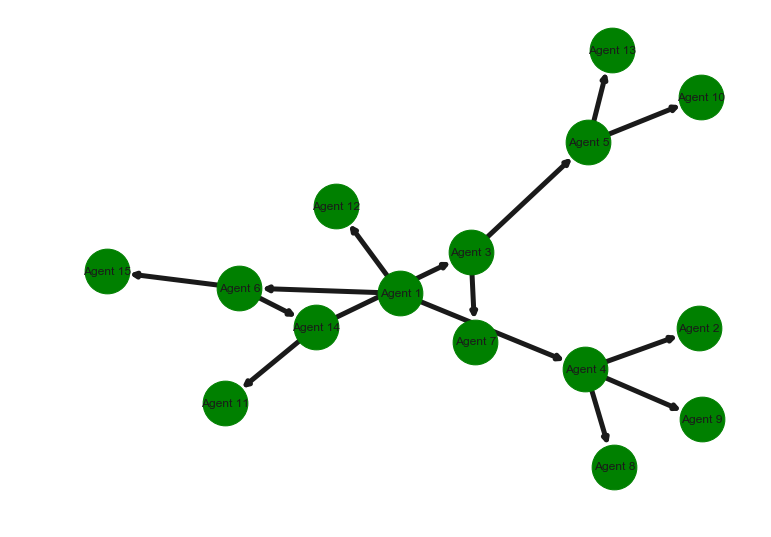

In [20]:
import networkx as nx 
labels = {}
for i in range(n):
    labels[i] = 'Agent {}'.format(i+1)
plt.figure(figsize=(10,7))
def show_graph_with_labels(adjacency_matrix , label):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    position = nx.layout.spring_layout(gr)
    nx.draw(nx.from_numpy_matrix(adjacency_matrix,create_using=nx.MultiDiGraph),position, node_size=2000, 
            labels=label , with_labels=True , node_color='green' , width=5)
    plt.show()
    
show_graph_with_labels(sol, labels)

## 2.3 Dimenstionnement d'une poutre

D'après l'énoncé de la question, on veut minimiser à la fois le poids et la déflexion d'une poutre :
\begin{equation}
p(a,b) = a^2 - b^2 \\
d(a,b) = \frac{10^{-3}}{10^{-2} + a^4 - b^4}
\end{equation}
sous les contraintes :
\begin{equation}
0.02 \le a \le 1 \\
0 \le b \le a - 0.01
\end{equation}

In [21]:
weight_fun = np.vectorize(lambda a,b : a**2 - b**2)
deflection_fun = np.vectorize(lambda a,b : 1e-3/(1e-2 + a**4 - b**4))

**Méthode gloutonne**

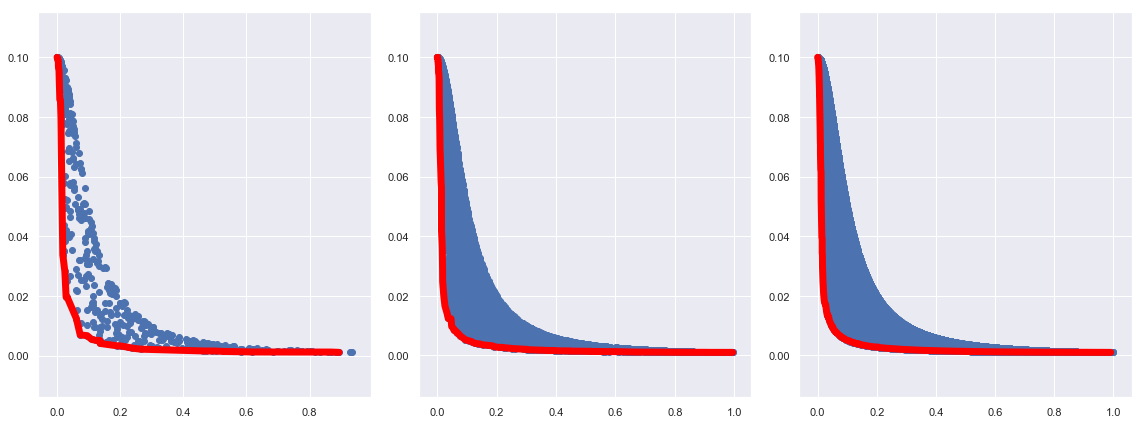

In [22]:
Ns = [500, 5000, 50000]

fig, ax = plt.subplots(1,len(Ns), figsize=(16,6))


for i in range(len(Ns)):
    
    a = np.random.uniform(0.02, 1, size = Ns[i])
    b = np.random.uniform(0 , 1, size = Ns[i])*(a - 0.01)
    weights, deflections = weight_fun(a,b), deflection_fun(a,b)
    
    sorted_list = sorted([[weights[i], deflections[i]] for i in range(len(a))])
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:] : 
        if pair[1] <= pareto_front[-1][1]: pareto_front.append(pair)

    pf_X = [pair[0] for pair in pareto_front]
    pf_Y = [pair[1] for pair in pareto_front]


    ax[i].scatter(weights, deflections)
    ax[i].plot(pf_X, pf_Y, c='red', linewidth = 7)
    

plt.tight_layout()
plt.show()

On voit très bien qu'on a besoin de beaucoup de points pour mieux estimer la frontière de Pareto.

50.000 points nous semble un bon compromis entre précision de l'estimation et temps de calcul.

Pour quantifier la performance de cette méthode, on essaye de voir le temps qu'elle prend pour nous construire la frontière.

In [23]:
from time import time
start = time()

N = 50000
a = np.random.uniform(0.02, 1, size = N)
b = np.random.uniform(0 , 1, size = N)*(a - 0.01)
weights, deflections = weight_fun(a,b), deflection_fun(a,b)

sorted_criterion = sorted([[weights[i], deflections[i]] for i in range(len(a))])
pareto = [sorted_criterion[0]]
for criterion in sorted_criterion[1:] : 
    if criterion[1] <= pareto[-1][1]: pareto.append(criterion)

pX = [criterion[0] for criterion in pareto]
pY = [criterion[1] for criterion in pareto]

print('Pour %d points, on obtient la frontière de Pareto après : '%N + str(round(time() - start,3))+' secondes')

Pour 50000 points, on obtient la frontière de Pareto après : 0.232 secondes


En terme d'évaluations des deux objectifs, le nombre d'évaluation est clairement le nombre de point, donc 50.000 dans notre cas.

Maintenant, on veut explorer une autre méthode pour estimer la frontière de Pareto qui peut s'avèrer plus efficace.

**Méthode mono objectif paramétrée**

On peut voir que la frontière de Pareto est bien convexe, on peut donc utiliser la méthode de pondération pour obtenir les solutions Pareto optimales. pour $\alpha$ donnée, on résoud le critère qui s'écrit:

$$J(a,b) = (1- \alpha)p(a,b) + \alpha d(a,b)$$

En faisant varier $\alpha$ de 0 à 1, on peut reconstruire la surface de Pareto.

In [24]:
from scipy.optimize import minimize

def criterion(x,alpha):
    return alpha*weight_fun(x[0],x[1]) + (1-alpha)*deflection_fun(x[0],x[1])

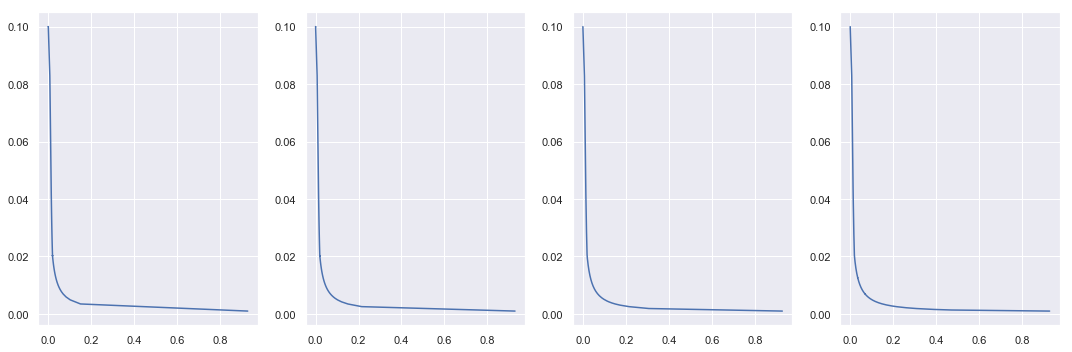

In [25]:
from time import time
start = time()

Ns = [50,100,200,1000]
fig, ax = plt.subplots(1,len(Ns), figsize=(15,5))
iters = []

for i in range(len(Ns)):
    
    alphas = np.linspace(0,1,Ns[i])
    num_iter = 0

    x0 = [0.5,0.4]
    constraints = {'type': 'ineq','fun' : lambda x: x[0]- x[1] - 0.01}
    bounds = [(0.02, 1),(0, 1)]

    optimal_sols, pareto_x, pareto_y  = [], [], []

    for alpha in alphas:
        results = minimize(criterion, x0, method= 'SLSQP', args=(alpha), constraints = constraints, bounds=bounds)
        x_min = results['x']
        num_iter += results['nit']
        optimal_sols.append(x_min)
        pareto_x.append(weight_fun(x_min[0], x_min[1]))
        pareto_y.append(deflection_fun(x_min[0], x_min[1]))

    ax[i].plot(pareto_x, pareto_y)
    
    iters.append(num_iter)
    
plt.tight_layout()
plt.show()

En ce qui concerne la qualité de l'estimation, voyons si la courbe récupérée minore les 50.000 points générés précédemment.

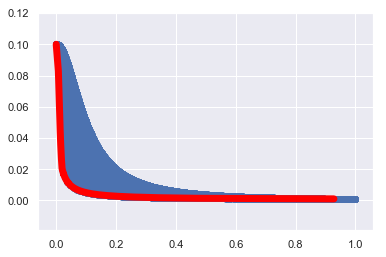

In [26]:
plt.scatter(weights, deflections)
plt.plot(pareto_x, pareto_y, c ='red', linewidth = 7)
plt.show()

On peut voir que l'estimation de la frontière de Pareto devient très précise en prenant 1000 valeurs de $\alpha$. 

Clairement, la méthode mono objectif donne une meilleure estimation de la frontière de Pareto, mais necéssite une hypothèse de convexité en plus pour que ça marche.

On peut comparer aussi le nombre d'évaluation des deux critères des deux méthodes.

In [27]:
print("le nombre d'évaluation des deux critères pour la mono objectif est: ",iters[-1] )

le nombre d'évaluation des deux critères pour la mono objectif est:  8157


Effectivement, la méthode mono objectif a besoin de moins d'itération pour arriver à une estimation précise.

Cette méthode donc surpasse la gloutonne dans tous les aspects.

## 2.4 Approvisionnement d'un chantier (optimisation combinatoire) 

Pour chaque jour de construction, l'entreprise a besoin d'un nombre $d_t$ d'engins chaque semaine et veut adopter une stratégie pour minimiser leur dépense sachant que chaque décision qu'elle prend est tarifée différemment. 

- acheminement sur chantier : 800
- tarif location/semaine : 200
- récupération sur chantier : 1200


Le problème peut se modéliser comme un problème de flux dans un graphe, avec un coût global $ F_{global} = 800 Entrant + 200 Passant + 1200 Sortant$ à minimiser, avec des flux définis respéctivement comme la somme de tous les flux (entrant, sortant et passant) sur toutes les semaines. Les flux pour chaque $t$ doivent être des **entiers positifs**, doivent respecter la contrainte de la demande et aussi respecter une contrainte de conservation. Mathématiquement ça se traduit par des contraintes de:

Integrité :
- $Entrant_t \ge 0 \quad \forall t$
- $Passant_t \ge 0 \quad \forall t$
- $Sortant_t \ge 0 \quad \forall t$

Demande :
- $Entrant_0 = Demande_0 $
- $Passant_t + Entrant_{t+1} \ge Demande_{t+1} \quad \forall t$


Conservation :
- $Entrant_0 = Passant_0 + Sortant_0 $
- $Entrant_N + Passant_{N-1} =  Sortant_N $
- $Entrant_{t} + Passant_{t-1} =  Sortant_t + Passant_t \quad \forall t$


<p align="center">
    <br><br>
  <img src="approvisionnement.png">
</p>

In [29]:
engins=np.loadtxt("DonneesEnginsChantier.txt")
n=engins.shape[0]

#Define variables : 
Entree = cp.Variable(n,integer=True)
Sortie = cp.Variable(n,integer=True)
Reste = cp.Variable(n-1,integer=True)
#Define constraints : 
constraints = []
#Contraints to satisfy demand 
constraints = constraints + [Entree[0] >= engins[0]]
for i in range(1,n) : 
    constraints = constraints + [Entree[i] + Reste[i-1] >= engins[i]]
#Constraints of conservation of flux
constraints = constraints + [Entree[0] == Reste[0] + Sortie[0]]
constraints = constraints + [Entree[n-1] + Reste[n-2] == Sortie[n-1]]
for i in range(1,n-1) : 
    constraints = constraints + [Entree[i] + Reste[i-1] == Reste[i] + Sortie[i]]
#Contraints of integrity    
constraints = constraints + [Entree[i] >= 0 for i in range(n)] 
constraints = constraints + [Sortie[i] >= 0 for i in range(n)] 
constraints = constraints + [Reste[i] >= 0 for i in range(n-1)] 
#Define objective
obj = cp.Minimize(800*cp.sum(Entree)+1200*cp.sum(Sortie)+200*cp.sum(Reste))
prob = cp.Problem(obj,constraints)
prob.solve()

print("Status de l'optimisation : {}".format(prob.status))
print("Le coût total : {}".format(prob.value))

Status de l'optimisation : optimal
Le coût total : 3248400.0


In [30]:
Entree_optimal = Entree.value
Sortie_optimal =  Sortie.value
Reste_optimal = Reste.value
Cout_optimal = np.zeros(n)
Cout_glouton = np.zeros(n)
Cout_glouton[0] = 800*engins[0] 
for i in range(1,n-1) : 
    Cout_glouton[i] = 200*engins[i] + 800*max(engins[i+1]-engins[i],0) + 1200*max(engins[i]-engins[i+1],0)
Cout_glouton[-1] = 1200*engins[-1]
Cout_glouton = np.cumsum(Cout_glouton)
Cout_optimal[0] = 800*Entree_optimal[0] 
for i in range(1,n-2) : 
    Cout_optimal[i] = 800*Entree_optimal[i] + 200*Reste_optimal[i-1] + 1200*Sortie_optimal[i-1]
Cout_optimal[-1] = 1200*Sortie_optimal[-1]    
Cout_optimal = np.cumsum(Cout_optimal)

engins_opt = np.zeros(n)
engins_opt[0] = Entree_optimal[0]
for i in range(1,n) : 
    engins_opt[i] = Entree_optimal[i] + Reste_optimal[i-1]


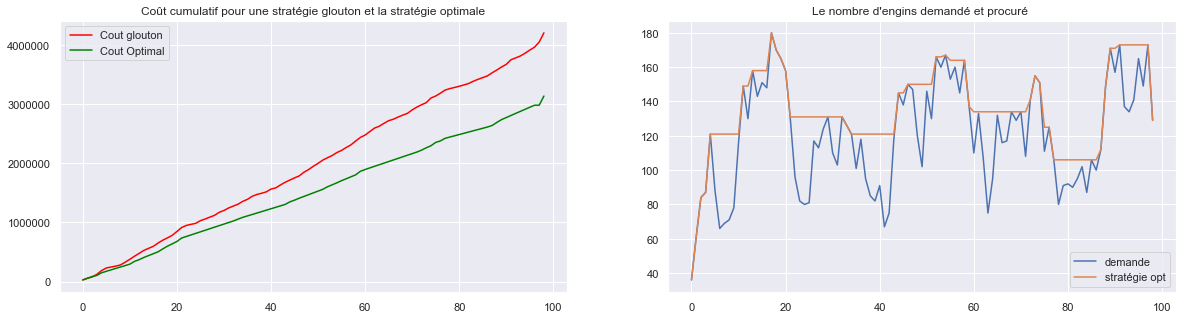

In [31]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(np.arange(n),Cout_glouton , c='red',label='Cout glouton')
plt.plot(np.arange(n),Cout_optimal , c='green',label='Cout Optimal')
plt.title('Coût cumulatif pour une stratégie glouton et la stratégie optimale')
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.arange(n),engins,label='demande')
plt.plot(np.arange(n),engins_opt,label='stratégie opt')
plt.title("Le nombre d'engins demandé et procuré ")
plt.legend()
plt.show()

On voit clairement que notre stratégie est plus performante que la gloutonne.